In [3]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image



image 1/1 /Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg: 640x480 1 bordered, 597.0ms
Speed: 3.9ms preprocess, 597.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2776])
data: tensor([[4.0262e+01, 1.8838e+03, 4.0691e+03, 2.4515e+03, 2.7761e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (5848, 4132)
shape: torch.Size([1, 6])
xywh: tensor([[2054.6753, 2167.6465, 4028.8259,  567.7660]])
xywhn: tensor([[0.4973, 0.3707, 0.9750, 0.0971]])
xyxy: tensor([[  40.2624, 1883.7635, 4069.0884, 2451.5295]])
xyxyn: tensor([[0.0097, 0.3221, 0.9848, 0.4192]])


In [13]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results_tbtr(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.model.names[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:

# set image
image = "/Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg"
# perform inference
results = model.predict(image)

# observe results
print(results[0].boxes)



image 1/1 /Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg: 640x480 1 bordered, 668.9ms
Speed: 5.7ms preprocess, 668.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2776])
data: tensor([[4.0262e+01, 1.8838e+03, 4.0691e+03, 2.4515e+03, 2.7761e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (5848, 4132)
shape: torch.Size([1, 6])
xywh: tensor([[2054.6753, 2167.6465, 4028.8259,  567.7660]])
xywhn: tensor([[0.4973, 0.3707, 0.9750, 0.0971]])
xyxy: tensor([[  40.2624, 1883.7635, 4069.0884, 2451.5295]])
xyxyn: tensor([[0.0097, 0.3221, 0.9848, 0.4192]])


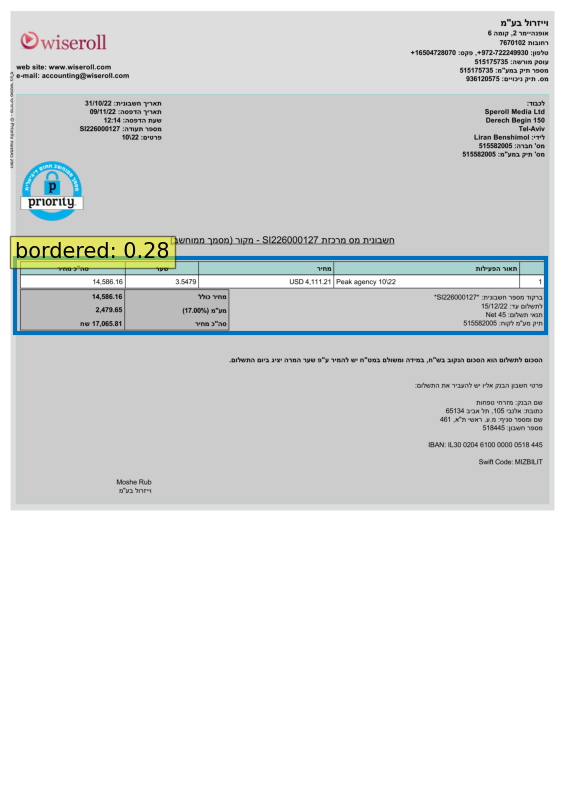

In [14]:
from PIL import Image
pil_img = Image.open(image)
plot_results_tbtr(pil_img,results[0].boxes.conf,results[0].boxes.cls, results[0].boxes.xyxy)

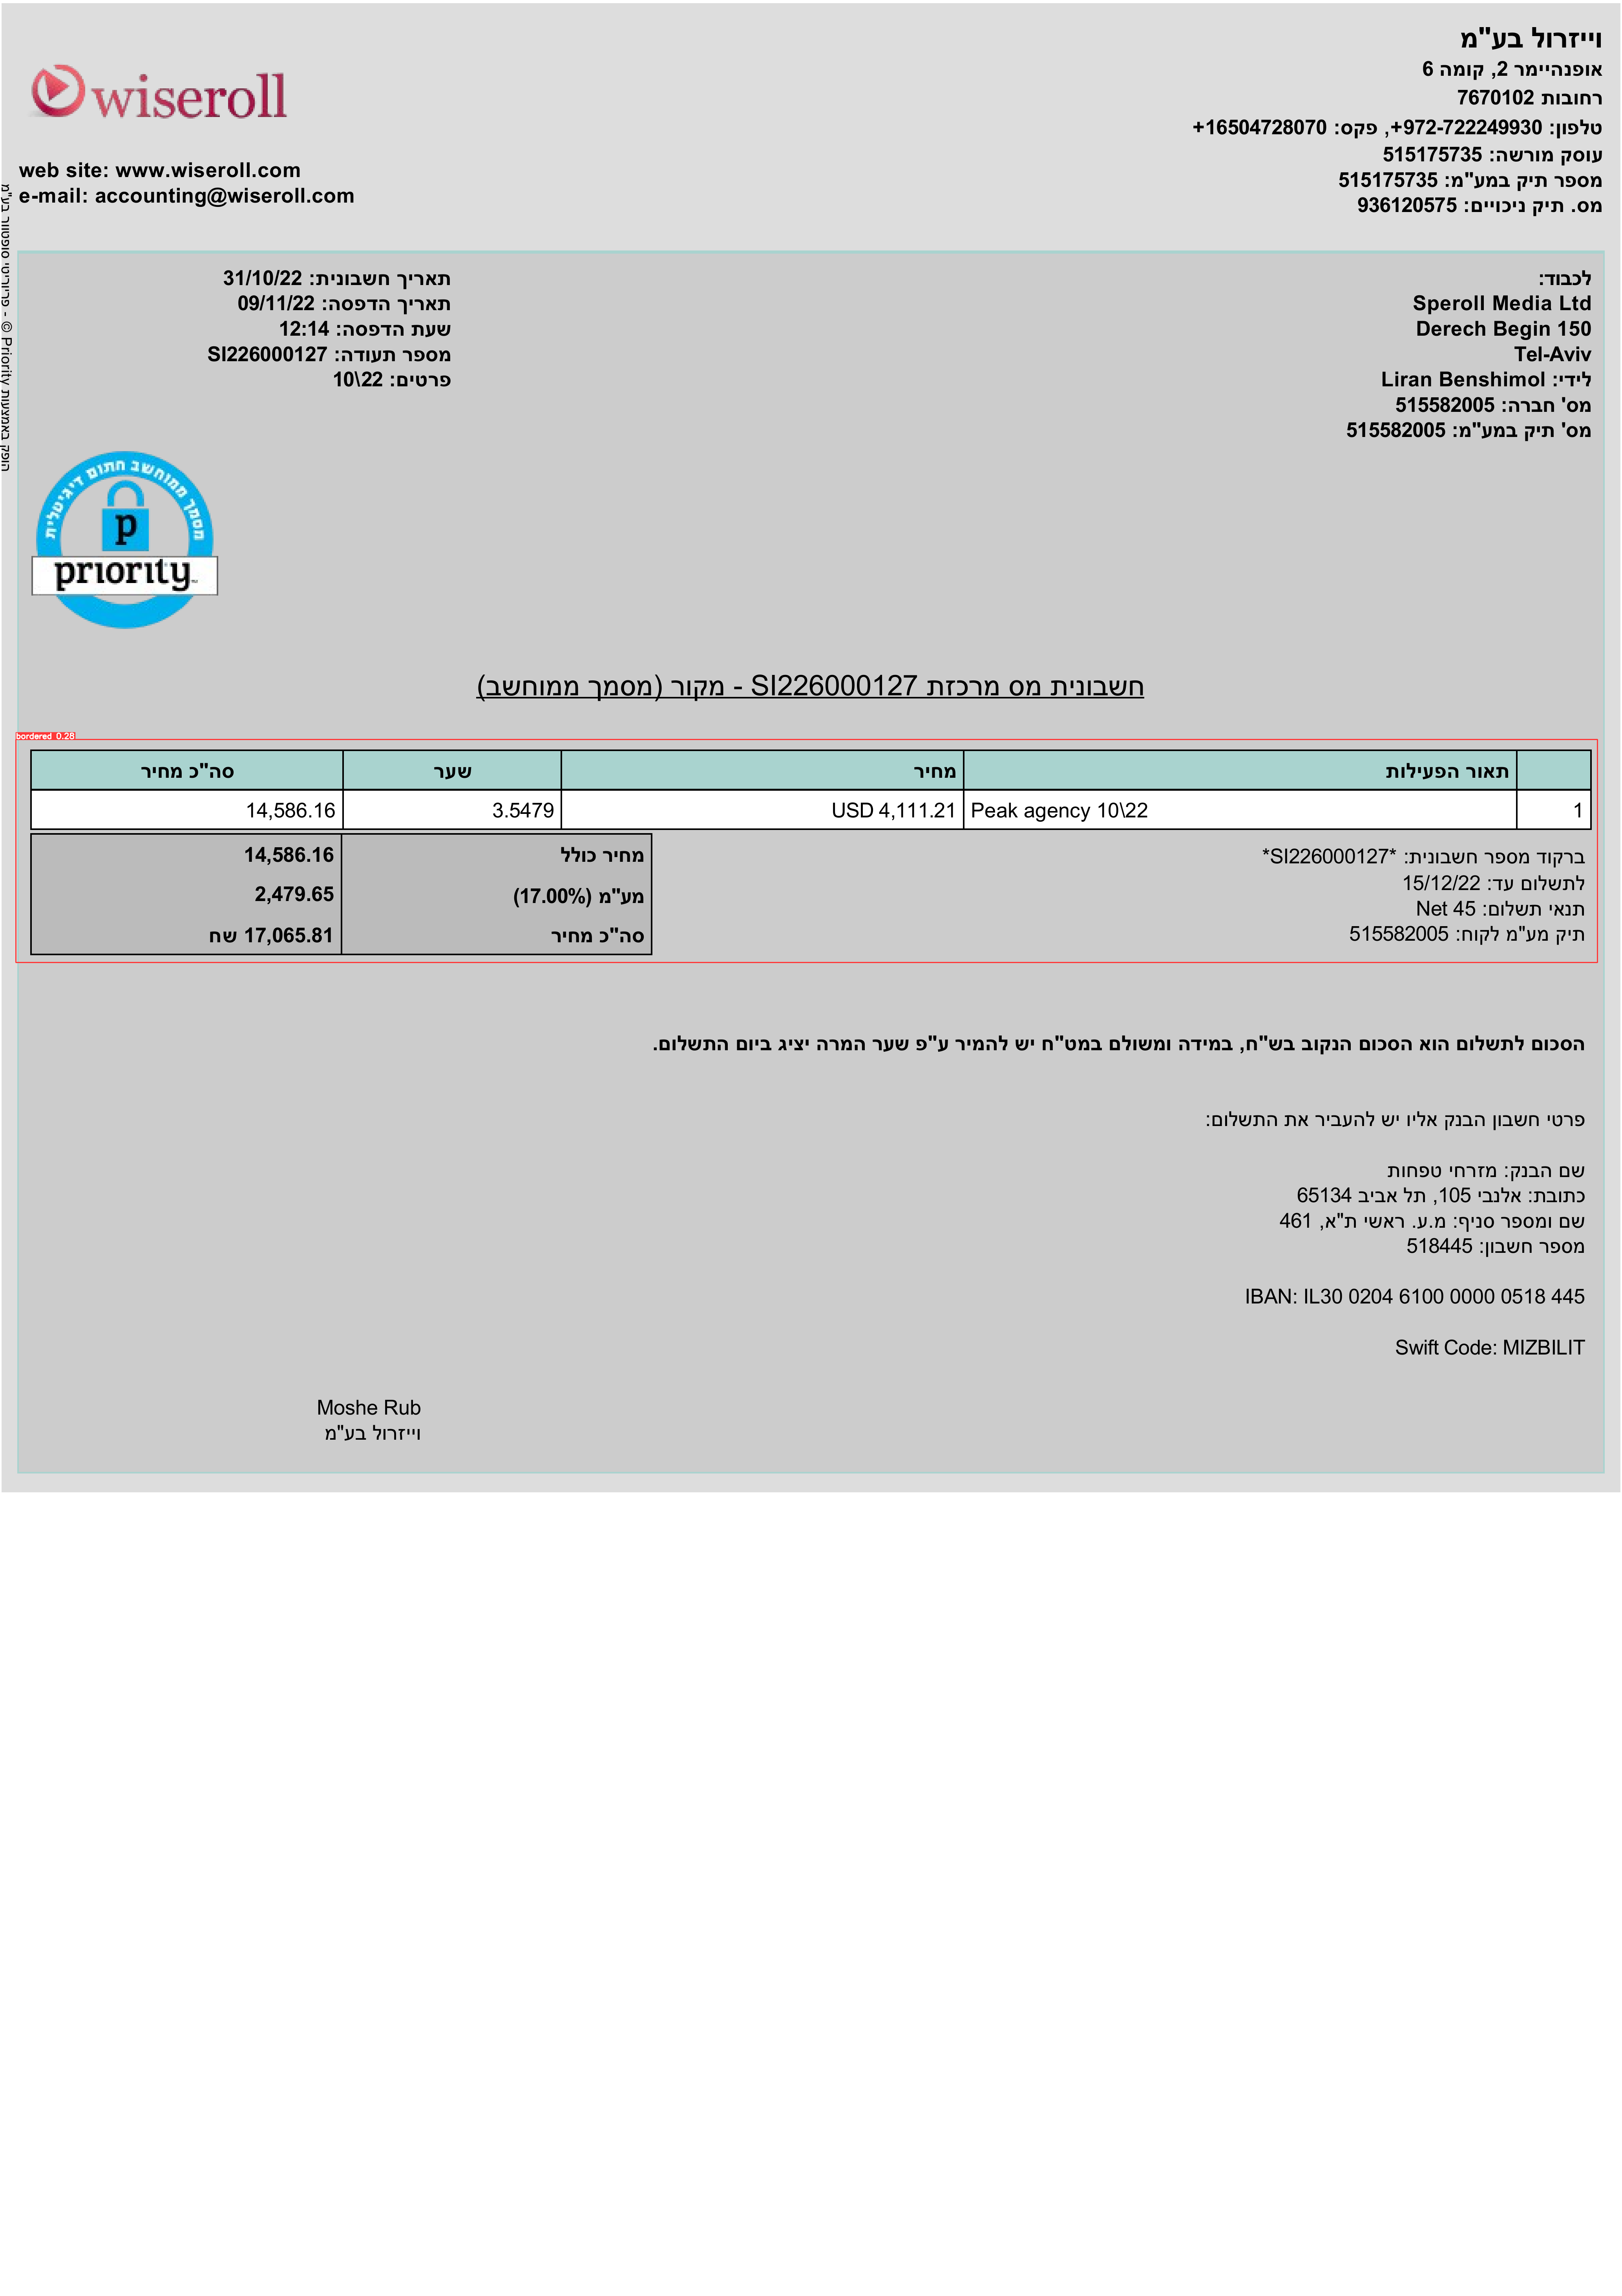

In [10]:
len(results)
render